In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime as dt, timedelta
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt, exp, log
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

In [2]:
df = pd.read_csv('data/for_modeling.csv', index_col='Year')
print(df.shape)
df.head()

(149, 6)


,Attend/G,HR,SO,SV,SO9,game_time_seconds
Year,,,,,,
1871,1439.0,0.19,0.69,0.02,0.7,7260.0
1872,1439.0,0.10,0.72,0.02,0.7,7260.0
1873,1439.0,0.12,0.70,0.02,0.7,7260.0
1874,1439.0,0.09,0.77,0.01,0.8,7260.0
1875,1439.0,0.06,0.98,0.03,1.0,7260.0


# Capstone 3 - Preprocessing and Modelling

## 1. Problem Description

Based on all previous years' data, is the dip in baseball attendance per game over the past few years (prior to the 2020) expected?

## 2. Test-Train Split

In [3]:
split_at = len(df)-15
data, validation = df[0:split_at], df[split_at:]
print('Train %d, Test %d' % (len(data),len(validation)))

Train 134, Test 15


In [4]:
validation.head()

,Attend/G,HR,SO,SV,SO9,game_time_seconds
Year,,,,,,
2005,30816.0,1.03,6.30,0.26,6.4,10140.0
2006,31306.0,1.11,6.52,0.25,6.6,10260.0
2007,32696.0,1.02,6.62,0.25,6.7,10500.0
2008,32382.0,1.00,6.77,0.24,6.8,10500.0
2009,30218.0,1.04,6.91,0.25,7.0,10500.0


## 3. Baseline - Persistence Model

In [5]:
apg = data['Attend/G']
X = apg.values
X = X.astype('float64')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    yhat = history[-1]
    predictions.append(yhat)
    obs = test[i]
    history.append(obs)
    #print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
    
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 1591.918


## 4. Data Analysis

In [6]:
apg = data['Attend/G']
apg.describe()

count      134.000000
mean     11076.223881
std       8752.070638
min       1439.000000
25%       3723.250000
50%       7779.000000
75%      15568.000000
max      31256.000000
Name: Attend/G, dtype: float64

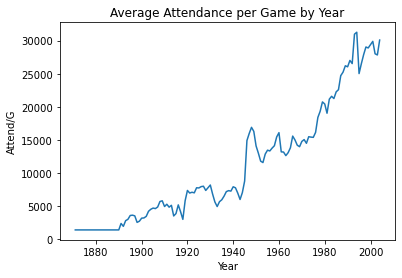

In [7]:
sns.lineplot(data=apg).set(title="Average Attendance per Game by Year");

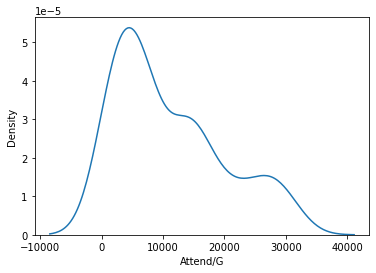

In [8]:
sns.kdeplot(data=apg);

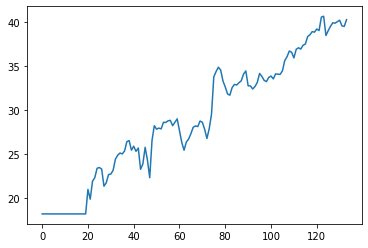

In [9]:

fitted_data, fitted_lambda = stats.boxcox(apg)

plt.plot(fitted_data)
plt.show()

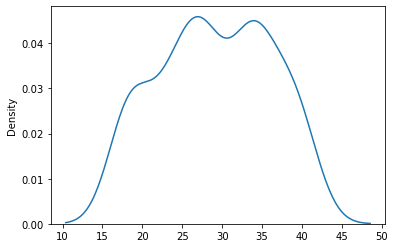

In [10]:
sns.kdeplot(fitted_data);

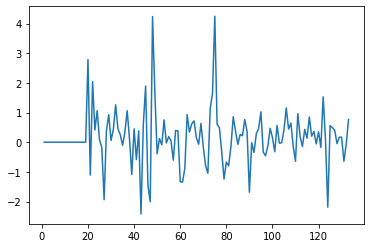

In [11]:
diff = pd.Series(fitted_data).diff()
sns.lineplot(data=diff.values);

In [12]:
diff = diff.dropna()
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.066297
p-value: 0.000000
Critical Values:
	1%: -3.481
	5%: -2.884
	10%: -2.579


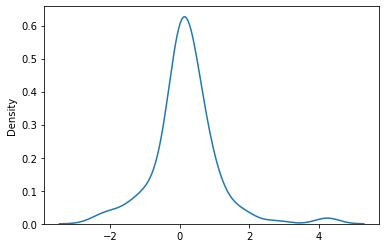

In [13]:
sns.kdeplot(diff);

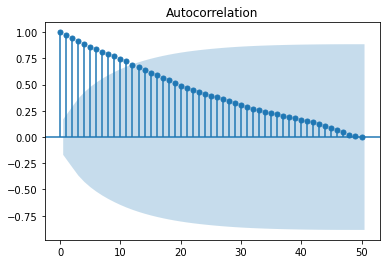

In [14]:
plot_acf(fitted_data, lags=50);

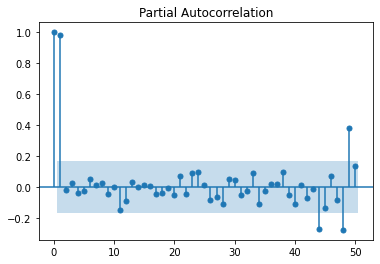

In [15]:
plot_pacf(fitted_data, lags=50);

## 5. ARIMA Model

In [16]:
X = fitted_data
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]

history = [x for x in train]
predictions = list()
for i in range(len(test)):
# predict
    model = ARIMA(history, order=(12,1,2))
    model_fit = model.fit(method_kwargs={"warn_convergence": False})
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)

rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

RMSE: 0.933


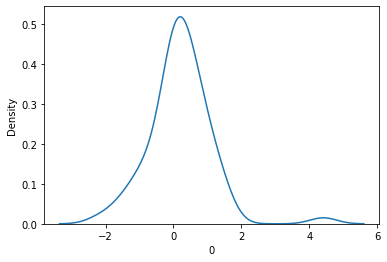

In [17]:
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
sns.kdeplot(residuals[0]);

## 6. Model Validation

In [18]:
# load data
series = apg
# prepare data
X = series.values
X = X.astype('float64')
# transform data
transformed, lam = stats.boxcox(X)
# fit model
model = ARIMA(transformed, order=(12,1,2))
model_fit = model.fit(method_kwargs={"warn_convergence": False})
# save model
model_fit.save('model.pkl')
np.save('model_lambda.npy', [lam])

In [19]:
def boxcox_inverse(value, lam):
  if lam == 0:
    return exp(value)
  return exp(log(lam * value + 1) / lam)
model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
print('Predicted: %.3f' % yhat)

Predicted: 29960.000


>Predicted=29960.000, Expected=30816.000
>Predicted=30654.826, Expected=28203.000
RMSE: 1157.780


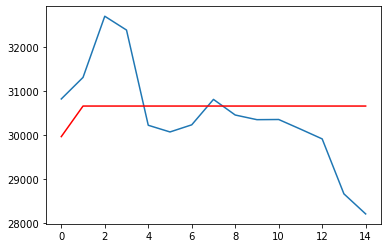

In [20]:
dataset = apg
history = [x for x in X]
validation = validation['Attend/G']
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
lam = np.load('model_lambda.npy')
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0]
yhat = boxcox_inverse(yhat, lam)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%.3f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
# transform
  transformed, lam = stats.boxcox(history)
  if lam < -5:
    transformed, lam = history, 1
# predict
  model = ARIMA(transformed, order=(0,1,2))
  model_fit = model.fit()
  yhat = model_fit.forecast()[0]
  # invert transformed prediction
  yhat = boxcox_inverse(yhat, lam)
  predictions.append(yhat)
# observation
obs = y[i]
history.append(obs)
print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %.3f' % rmse)
plt.plot(y)
plt.plot(predictions, color='red') 
plt.show()

## Resources

Code in this notebook has been adapted from: 

Jason Brownlee (2020). *Introduction to Time Series Forcasting with Python.*